AutoEncoder-based Anomaly Detection

In [66]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'


In [67]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


Using device: cpu


In [68]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y = data['Engine Condition']
y_origin = pd.Series(y)

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング

In [69]:
def get_new_dataloader(X_scaled, y_origin, batch_size,test_size=0.2,):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_origin, test_size=test_size, shuffle=True, stratify=y_origin, random_state=42
    )

    # 正常データのみを学習に
    X_train_norm = X_train[y_train == 0] #0
    y_train_norm = y_train[y_train == 0]

    # Tensor に変換
    X_train_tensor = torch.tensor(X_train_norm, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test,      dtype=torch.float32)
    y_test_tensor  = torch.tensor(y_test.values, dtype=torch.int64)

    train_ds = TensorDataset(X_train_tensor)
    test_ds  = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [70]:
class Encoder(nn.Module):#PMforAM
    def __init__(self, input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage
        output_dim = int(input_dim // leverage)
        phase = torch.rand(output_dim, input_dim) * 2 * np.pi - np.pi
        modulus = torch.rand(output_dim, input_dim)

        real_part = modulus * torch.cos(phase)
        imag_part = modulus * torch.sin(phase)

        self.B = torch.complex(real_part, imag_part).detach().to(device)
        self.B.requires_grad = False

        self.alpha = torch.rand(input_dim) * 0.5 + 0.5
        self.alpha = self.alpha.detach().to(device)
        self.alpha.requires_grad = False

    def forward(self, x):
        x = torch.exp(1j * self.alpha * x)
        x = torch.matmul(self.B, x.T).T
        x = torch.abs(x)**2
        return x

In [71]:
#EncoderLI
class EncoderLI(nn.Module):
    def __init__(self,input_dim, leverage):
        super(EncoderLI, self).__init__()
        self.leverage = leverage
        output_dim = int(input_dim // leverage)
        self.B = nn.Parameter(torch.randn(output_dim, input_dim) * (input_dim))#.to(device)
        self.B.requires_grad = True

    
    def forward(self, x):
        x = x.T
        x = torch.matmul(self.B,x)
        x = x.T
       
        return x

In [72]:

class MLP(nn.Module):
    def __init__(self, potential_dim, out_dim):
        super(MLP,self).__init__()

        mid1 = int((potential_dim+out_dim)/2)
        self.fc1 = nn.Linear(potential_dim,mid1)
        self.fc2 = nn.Linear(mid1, out_dim)
        self.func = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.func(x)
        x = self.fc2(x)
        return x

In [73]:
class AE_AnoDec(nn.Module):
    def __init__(self,input_dim, leverage):
        super(AE_AnoDec, self).__init__()
        potential_dim = int(input_dim//leverage)
        self.encoder = EncoderLI(input_dim,leverage,) 
        self.norm = nn.LayerNorm(potential_dim)
        self.decoder =  MLP(potential_dim,input_dim)
        
    def forward(self, x):
        x = self.encoder(x) 
        x = self.norm(x)
        x = self.decoder(x)
        return x

1/1th Time Epoch: 100/100

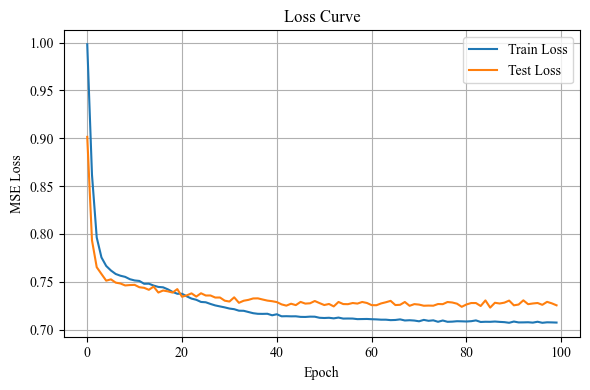

ROC AUC: 0.5311


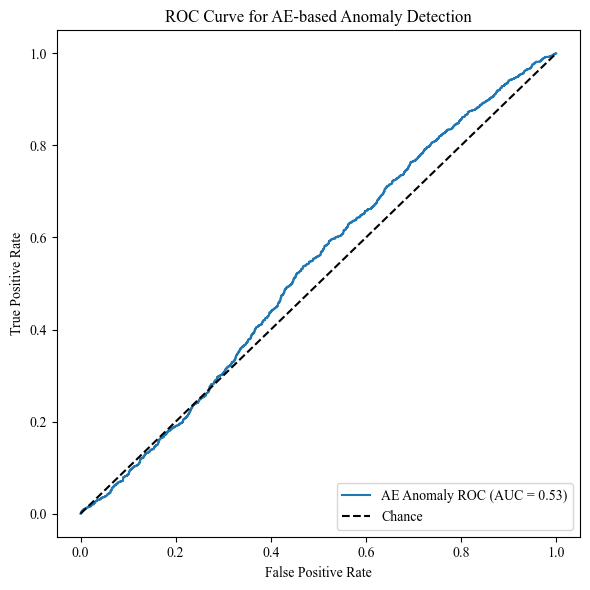


ROC AUC: 0.5311
Best F1: 0.7734 @ Threshold = 0.017142


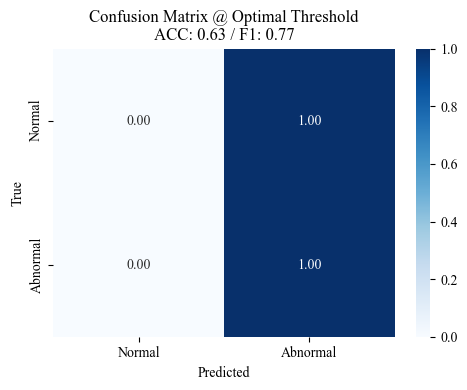

In [74]:
input_dim = X_scaled.shape[1]
leverage = 2  # 圧縮倍率
max_epochs = 100
lr = 1e-3 #学習率
batch_size = 32

num_try = 1 #

All_last_loss = []
All_loss_test = []
All_pro_time = []
All_test_acc = []

for num_times in range(num_try): 
    train_dataloader, test_dataloader = get_new_dataloader(X_scaled,y_origin,batch_size)
    model = AE_AnoDec(input_dim,leverage).to(device)
    criterion = nn.MSELoss(reduction='mean')
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_train_ = []
    loss_test_ = []
    pro_time_ = []

    for epoch in range(max_epochs):
        model.train()
        epoch_loss_train = 0
        sys.stderr.write('\r%d/%dth Time Epoch: %d/%d' % (num_times+1,num_try, epoch+1, max_epochs))
        sys.stderr.flush()

        start_time1 = time.time()
        for (batch_X,) in train_dataloader:
            batch_X = batch_X.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_X)
            loss.backward()
            optimizer.step()

            epoch_loss_train += loss.item()

        epoch_loss_train /= len(train_dataloader)
        loss_train_.append(epoch_loss_train)
        end_time1 = time.time()
        pro_time_.append(end_time1-start_time1)

        # テスト損失計算
        model.eval()
        mse_scores  = []
        true_labels = []
        with torch.no_grad():
            test_loss = 0.0
            for batch_x, batch_y in test_dataloader:
                batch_x = batch_x.to(device)
                outputs = model(batch_x).to(device)
                loss = criterion(outputs, batch_x)
                test_loss += loss.item()
                batch_mse = ((outputs - batch_x) ** 2).mean(dim=1)
                mse_scores.extend(batch_mse.cpu().numpy())
                true_labels.extend(batch_y.cpu().numpy())
            test_loss /= len(test_dataloader)
            loss_test_.append(test_loss)

    plt.figure(figsize=(6,4))
    plt.plot(loss_train_, label="Train Loss")
    plt.plot(loss_test_, label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Loss Curve")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fpr, tpr, thresholds = roc_curve(true_labels, mse_scores)
    roc_auc = auc(fpr, tpr)
    print(f"ROC AUC: {roc_auc:.4f}")

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AE Anomaly ROC (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], "k--", label="Chance")
    plt.xlabel("False Positive Rate")#正常のサンプルのうち間違って異常と検出した割合
    plt.ylabel("True Positive Rate")#異常のサンプルのうち異常と正しく判定をした割合
    plt.title("ROC Curve for AE-based Anomaly Detection")
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

    best_f1 = 0
    best_th = None
    for th in thresholds:
        preds = (np.array(mse_scores) > th).astype(int)
        f1 = f1_score(true_labels, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_th = th

    print(f"\nROC AUC: {roc_auc:.4f}")
    print(f"Best F1: {best_f1:.4f} @ Threshold = {best_th:.6f}")

    #── 混同行列（最適閾値に基づく2値分類）──

    y_pred = (np.array(mse_scores) > best_th).astype(int)
    cm = confusion_matrix(true_labels, y_pred)
    cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
    accuracy = accuracy_score(true_labels, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues", xticklabels=["Normal", "Abnormal"], yticklabels=["Normal", "Abnormal"],vmin=0.0, vmax=1.0)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix @ Optimal Threshold\nACC: {accuracy:.2f} / F1: {best_f1:.2f}")
    plt.tight_layout()
    plt.show()
